# Regresión con Árboles de decisión

Importar bibliotecas

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Cargar datos

In [ ]:
# Cargar datos
df = pd.read_csv('../../datasets/churn/churn_data.csv')

1. Análisis exploratorio

In [3]:
print("Resumen estadístico:")
print(df.describe(include='all'))

print("\nValores nulos por columna:")
print(df.isnull().sum())

Resumen estadístico:
          country      city           name  signupDate lastLoginDate  \
count      200000    200000         200000      200000        200000   
unique         30       440         120324        1095          1088   
top     Indonesia  San Juan  Michael Smith  2022-06-25    2025-05-02   
freq         6839       925             86         223          1215   
mean          NaN       NaN            NaN         NaN           NaN   
std           NaN       NaN            NaN         NaN           NaN   
min           NaN       NaN            NaN         NaN           NaN   
25%           NaN       NaN            NaN         NaN           NaN   
50%           NaN       NaN            NaN         NaN           NaN   
75%           NaN       NaN            NaN         NaN           NaN   
max           NaN       NaN            NaN         NaN           NaN   

        subscriptionType  usageFrequency  watchTimePerWeek  preferredDevice  \
count      200000.000000   200000.0

Histograma de la variable objetivo

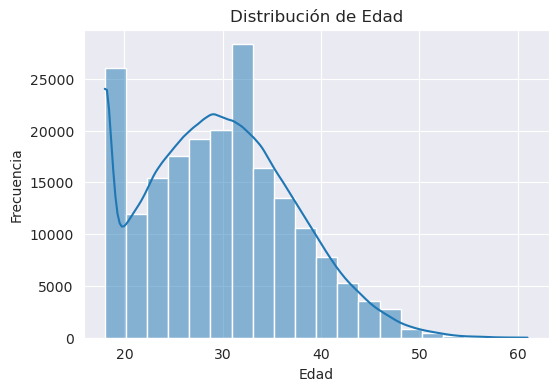

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Boxplot de edad por tipo de suscripción

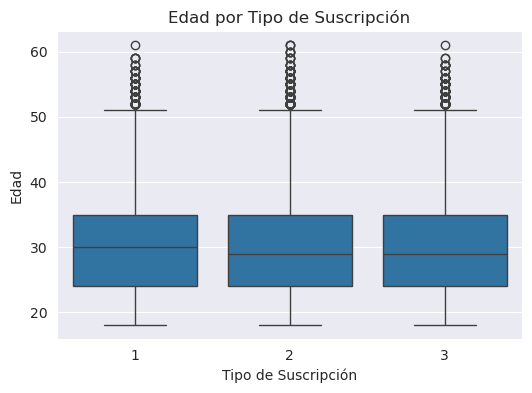

In [5]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='subscriptionType', y='age')
plt.title('Edad por Tipo de Suscripción')
plt.xlabel('Tipo de Suscripción')
plt.ylabel('Edad')
plt.show()

Pairplot con algunas variables numéricas relevantes


<Figure size 640x480 with 0 Axes>

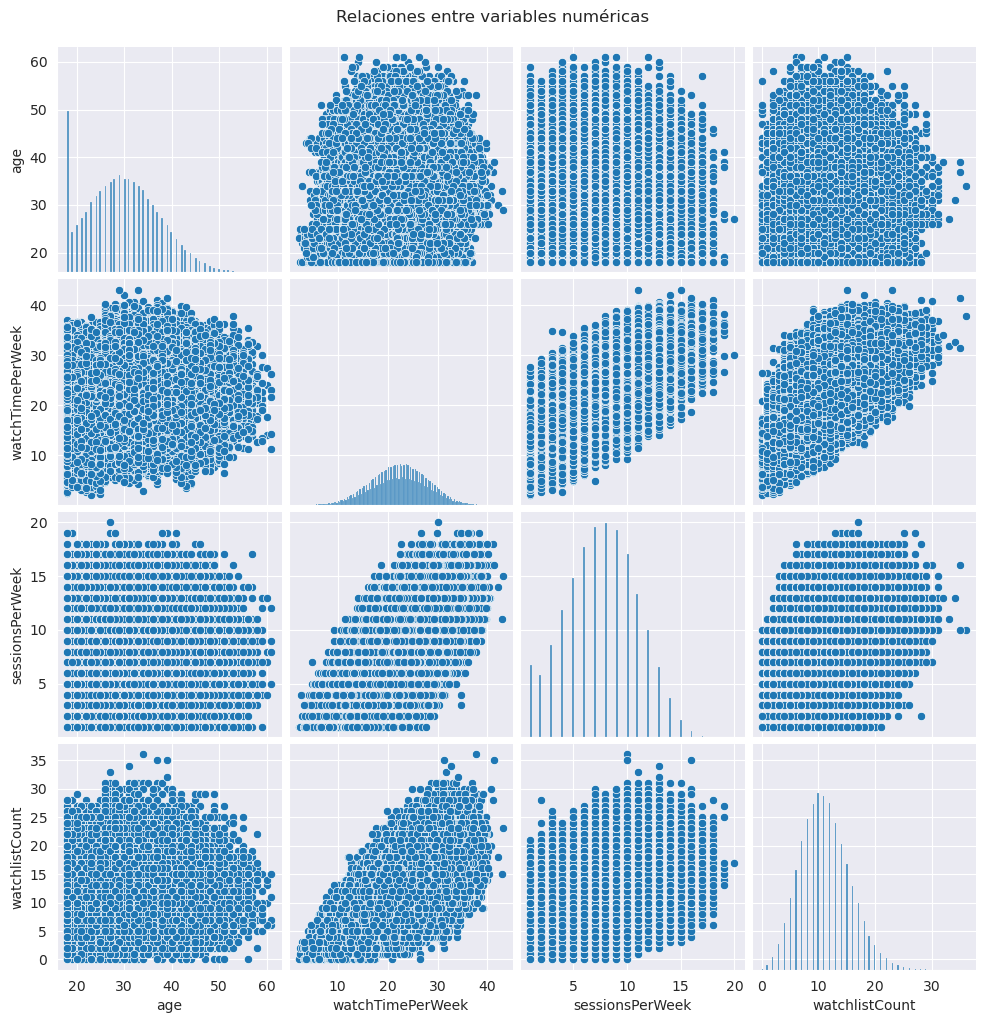

In [6]:
plt.figure()
sns.pairplot(df[['age', 'watchTimePerWeek', 'sessionsPerWeek', 'watchlistCount']])
plt.suptitle('Relaciones entre variables numéricas', y=1.02)
plt.show()

Heatmap de correlaciones

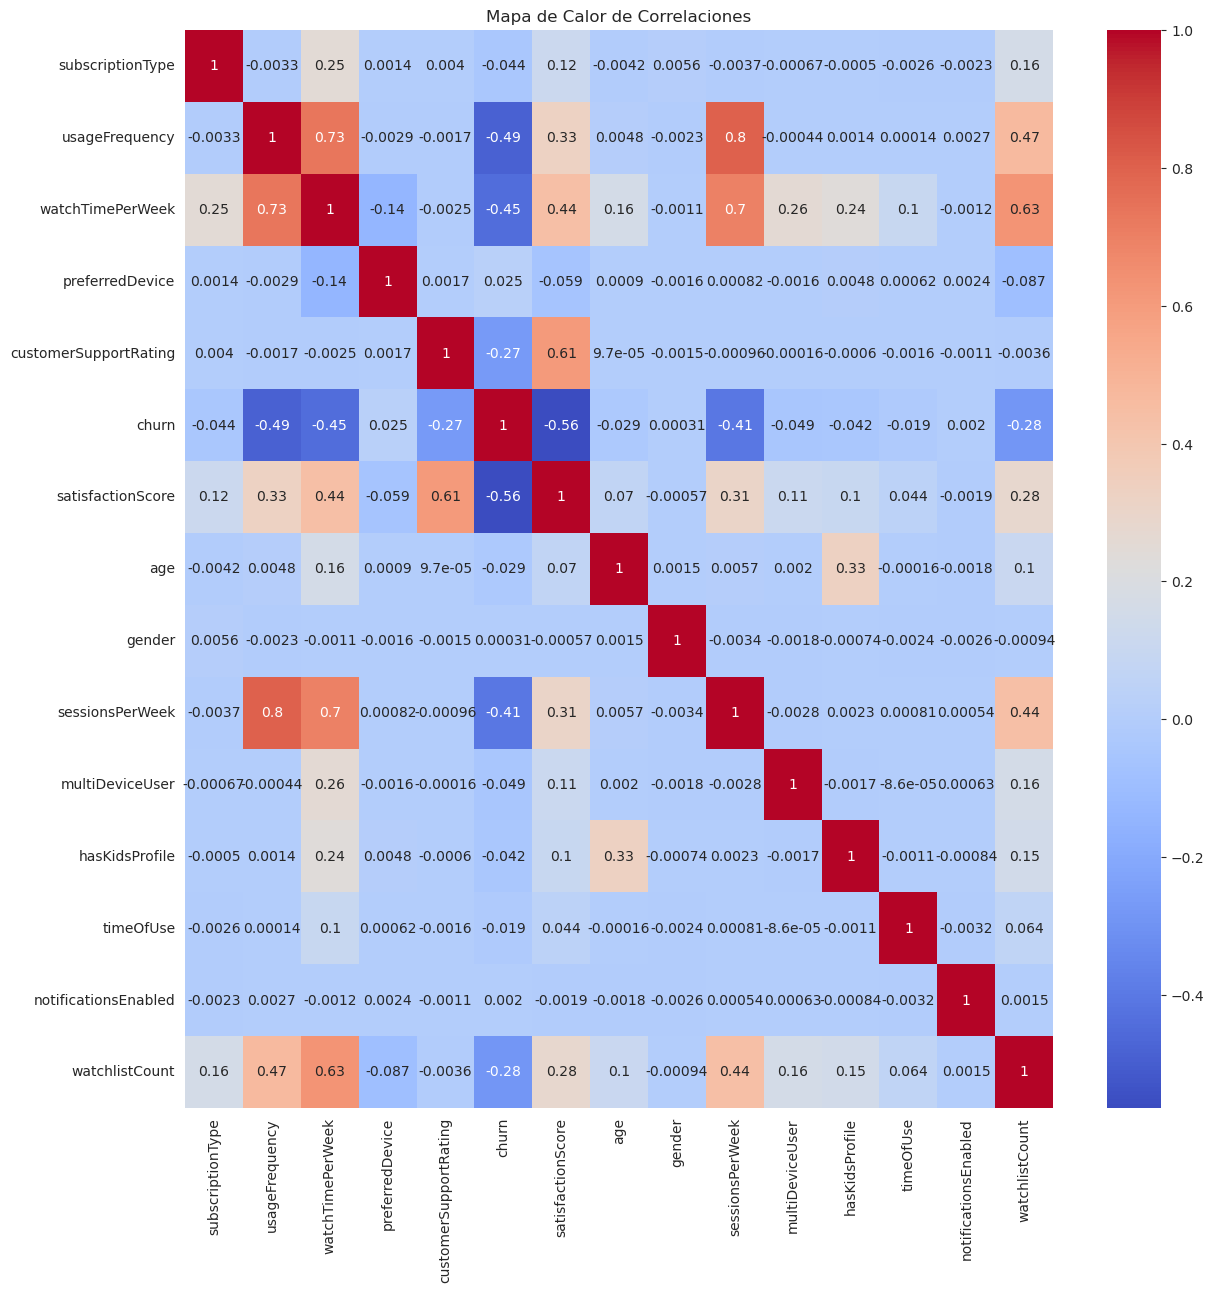

In [7]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

2. Limpieza de datos

Eliminar columnas que no aportan a la predicción

In [8]:
cols_to_drop = ['name', 'country', 'city', 'signupDate', 'lastLoginDate', 'gender']
df.drop(columns=cols_to_drop, inplace=True)

3. Transformación de variables

Crear variables derivadas de fechas

In [ ]:
# from scripts.categories import categories_map
# df["preferred"] = df["preferredCategory"].apply(lambda x: categories_map.get(x, 0))
# df["last_watched"] = df["lastWatchedCategory"].apply(lambda x: categories_map.get(x, 0))
# df.drop(columns=['preferredCategory', 'lastWatchedCategory'], inplace=True)

{'Action': 0, 'Comedy': 1, 'Drama': 2, 'Documentary': 3, 'Kids': 4, 'Horror': 5, 'Sci-Fi': 6, 'Romance': 7, 'Western': 8}


4. Separación X e y

In [12]:
X = df.drop(columns=['watchTimePerWeek'])
y = df['watchTimePerWeek']

5. Preprocesamiento

In [13]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

6. Modelo y Pipeline

In [40]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(
        max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=10
    ))
])

Dividir los datos

In [41]:
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenar el modelo

In [42]:
model.fit(df_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['subscriptionType',
                                                   'usageFrequency',
                                                   'preferredDevice',
                                                   'customerSupportRating',
                                                   'churn', 'satisfactionScore',
                                                   'age', 'sessionsPerWeek',
                                                   'multiDeviceUser',
                                                   'hasKidsProfile',
                                                   'timeOfUse',
                                                   'notificationsEnabled',
                                                   'watchlistCount',
                                                   'preferred',
                                                   'last_watched']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_leaf=4,
                                       min_samples_split=10))])

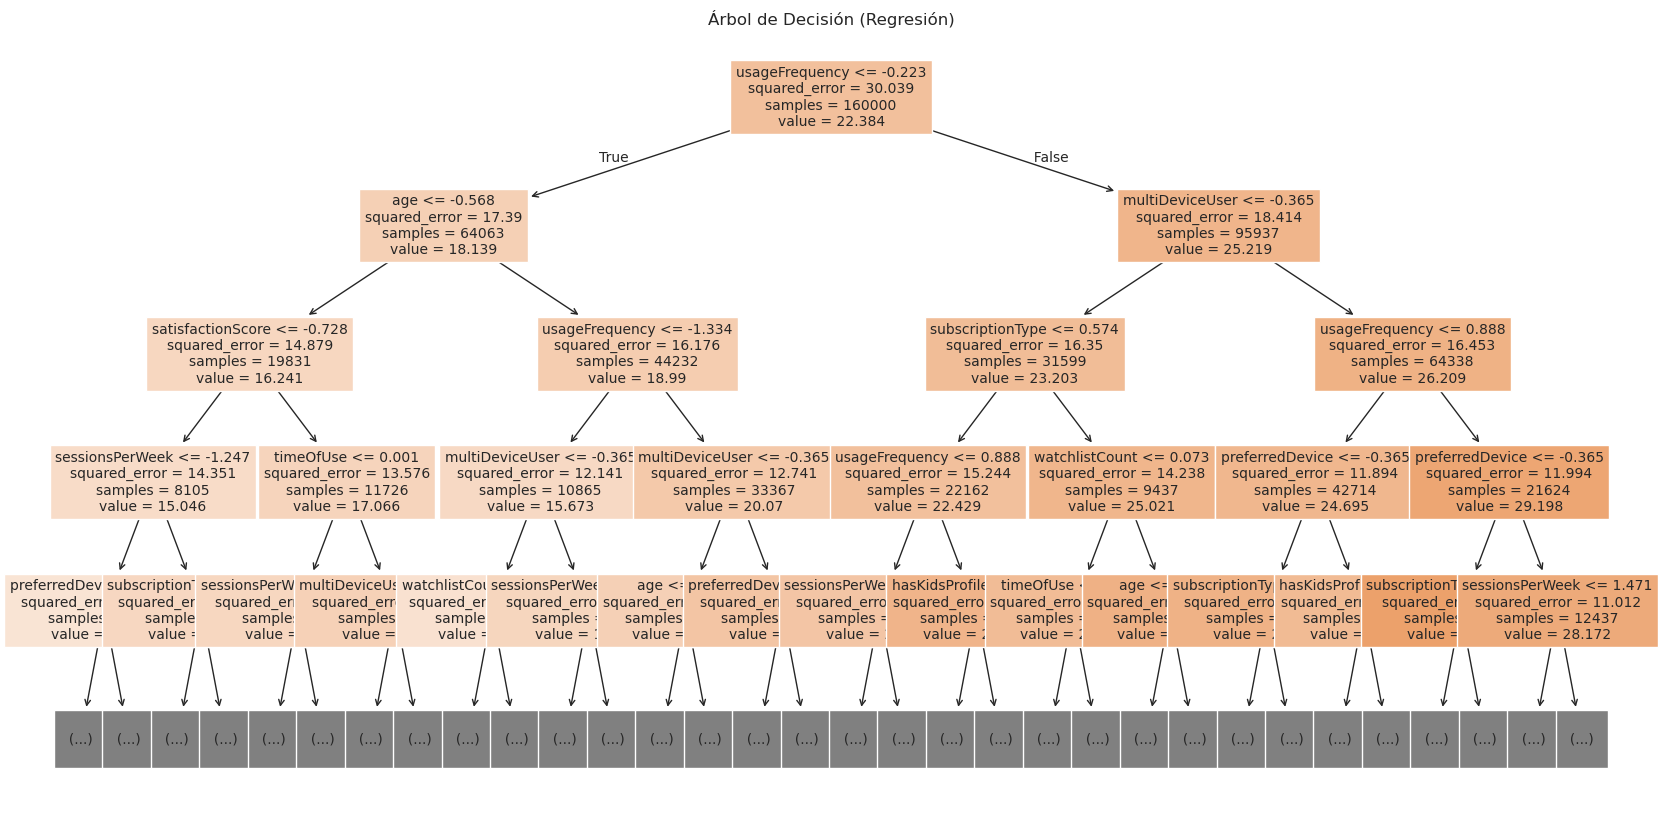

In [43]:
from sklearn.tree import plot_tree
# Obtener nombres de las features luego del OneHotEncoding
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(model.named_steps['regressor'], feature_names=X.columns, filled=True, max_depth=4, fontsize=10)
plt.title('Árbol de Decisión (Regresión)')
plt.show()

Predicciones

In [44]:
y_pred = model.predict(df_test)

7. Evaluación

In [45]:
print("\nEvaluación del modelo:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


Evaluación del modelo:
MAE: 1.9127834982102654
RMSE: 2.4087932039862
R2: 0.806394406743549


## Encontrar mejores parámetros

In [37]:
param_grid = {
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)



In [38]:
grid_search.fit(df_train, y_train)

/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/tuteggito/miniconda3

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['subscriptionType',
                                                                          'usageFrequency',
                                                                          'preferredDevice',
                                                                          'customerSupportRating',
                                                                          'churn',
                                                                          'satisfactionScore',
                                                                          'age',
                                                                          'sessionsPerWeek',
                                                                          'multiDeviceUser',
                                                                          'hasKidsProfile',
                                                                          'timeOfUse'...
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('regressor', DecisionTreeRegressor())]),
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]})

In [39]:
print("\nMejores parámetros:")
print(grid_search.best_params_)


Mejores parámetros:
{'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}
